# Before Start
### install packages numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn by
> !pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

## Set proper path to read data

In [ ]:
import os
proper_path = os.getcwd()  ### Put path in instead of os.getcwd()
os.chdir(proper_path)

In [ ]:
import sys
sys.path.append(os.path.join(*str(os.getcwd()).split('\\')[:-1]).replace(':',':\\'))
import riemannian_robust_m_estimator as rrm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, time, pickle
import math
from scipy.stats import chi2

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian

import numpy as np
from scipy.stats import vonmises


# Simulation 1 for smeary test : sampling function

In [ ]:
# sampling function

def sample_from_mixture_vm_u_in_circle(n_samples,mu,kappa,unif_low,unif_upp,mixture_prob_1,return_before_mixture=False):
    # mu = 0         # center angle
    # kappa = 100.0       # kappa given
    # n_samples = 1000
    
    # 1) sampling angle(von-mises)
    theta = vonmises.rvs(kappa, loc=mu, size=n_samples)
    
    # 2) map to points on circle(S¹) 
    x = np.stack([np.cos(theta), np.sin(theta)], axis=-1)
    
    theta_op = np.random.uniform(unif_low,unif_upp,size=n_samples)
    x_op = np.stack([np.cos(theta_op), np.sin(theta_op)], axis=-1)

    mixture_mask = np.random.uniform(size=n_samples)<=mixture_prob_1

    sample = np.array([x[i,:] if m else x_op[i,:] for i,m in enumerate(mixture_mask)])
    theta_sample = np.array([theta[i] if m else theta_op[i] for i,m in enumerate(mixture_mask)])
    if return_before_mixture:
        return sample, theta_sample, theta, theta_op
    return sample, theta_sample


delta = np.pi/4
mixture_prob_1 = 1-delta/(2*np.pi)
kappa = 100

sample, theta_sample = sample_from_mixture_vm_u_in_circle(
    n_samples=100,
    mu=0,
    kappa=100,
    unif_low=np.pi-delta/2,
    unif_upp=np.pi+delta/2,
    mixture_prob_1=mixture_prob_1
)

## check working(plot : sample candidates of each distribution)

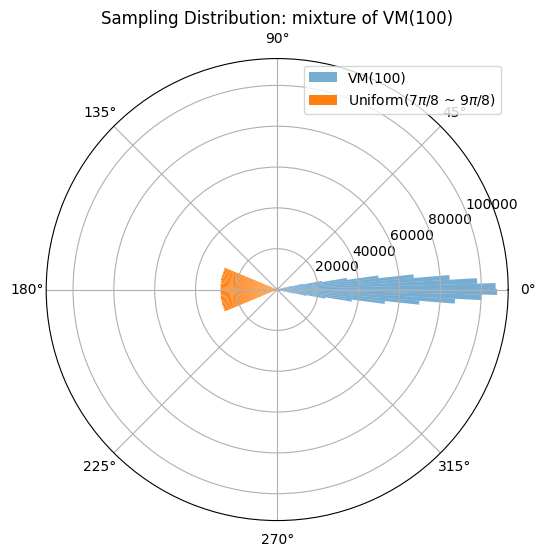

In [101]:
delta = np.pi/4
mixture_prob_1 = 1-delta/(2*np.pi)
kappa = 100

sample, theta_sample, theta, theta_op = sample_from_mixture_vm_u_in_circle(
    n_samples=1000000,
    mu=0,
    kappa=kappa,
    unif_low=np.pi-delta/2,
    unif_upp=np.pi+delta/2,
    mixture_prob_1=mixture_prob_1,
    return_before_mixture=True
)

plt.figure(figsize=(6,6))
plt.subplot(projection="polar")

plt.hist(theta,bins=36,alpha=0.6,label=f'VM({kappa:.0f})')
plt.hist(theta_op,bins=36,alpha=1,label='Uniform(7$\pi$/8 ~ 9$\pi$/8)')
plt.title(f"Sampling Distribution: mixture of VM({kappa:.0f})")
plt.legend()
plt.show()

# plot : Sampled data histogram from mixture distribution.

0.875


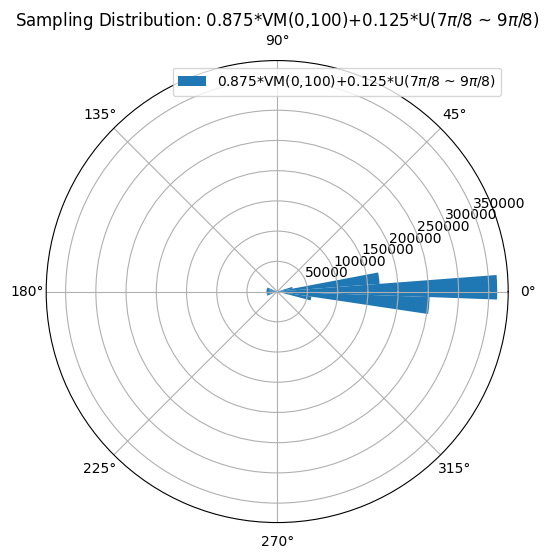

In [115]:
print(mixture_prob_1)
plt.figure(figsize=(6,6))
plt.subplot(projection="polar")
plt.hist(theta_sample,bins=36,alpha=1,label=f'{mixture_prob_1:.3f}*VM(0,{kappa:.0f})+{1-mixture_prob_1:.3f}*U(7$\pi$/8 ~ 9$\pi$/8)')
plt.title(f"Sampling Distribution: {mixture_prob_1:.3f}*VM(0,{kappa:.0f})+{1-mixture_prob_1:.3f}*U(7$\pi$/8 ~ 9$\pi$/8)")
plt.legend()
plt.show()


In [ ]:
## make warning alarm disappear

import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('root').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Old simulated data load(used in paper)

In [68]:
import pickle
folder = 'result_data_base'
with open(f'{folder}/var_of_sample_means_simul1.pkl','rb') as f_:
    var_of_sample_means = pickle.load(f_)
with open(f'{folder}/mean_of_sample_vars_simul1.pkl','rb') as f_:
    mean_of_sample_vars = pickle.load(f_)
with open(f'{folder}/var_of_sample_means_simul1_result_mean.pkl','rb') as f_:
    result_m = pickle.load(f_)

#with open(f'{folder}/var_of_sample_means_simul1_result_a.pkl','rb') as f_:
#    result_a = pickle.load(f_)

with open(f'{folder}/var_of_sample_means_simul2.pkl','rb') as f_:
    var_of_sample_means_ = pickle.load(f_)
with open(f'{folder}/mean_of_sample_vars_simul2.pkl','rb') as f_:
    mean_of_sample_vars_ = pickle.load(f_)
with open(f'{folder}/var_of_sample_means_simul2_result_mean.pkl','rb') as f_:
    result_m_ = pickle.load(f_)

#with open(f'{folder}/var_of_sample_means_simul2_result_a.pkl','rb') as f_:
#    result_a_ = pickle.load(f_)


## If processing simulation manually, below is the simulation 1 setting.

In [ ]:
delta = np.pi/4
mixture_prob_1 = 1-delta/(2*np.pi)
mixture_prob_1

mests = ['biweight','hampel','cauchy','huber_90','huber_45','frechet']
ns = [10,20,50,100,500,1000,5000,10000]
cc = Hypersphere(1)

# simulation 1 start

In [ ]:
cc = Hypersphere(1)

def squaredist(space,points,base,critical_value,weights=None,loss_and_grad=True):
    n = len(points)
    logs = space.metric.log(points,base)
    dists = space.metric.dist(points,base)

    loss = gs.sum(dists**2)/n
    if not loss_and_grad:
        return loss
    grad = -2*gs.sum(logs,axis=0)/n
    return loss, space.to_tangent(grad,base)

var_of_sample_means = {}
mean_of_sample_vars = {}
min_loss_sp = {}
result_m = {}
result_a = {}

# mests = ['biweight','hampel','cauchy','huber_90','huber_45','frechet']
# ns = [10,20,50,100,500,1000,5000,10000]
tic = time.time()
for n_samples in ns:
    print(f'{n_samples} start')
    result_m[n_samples] = {}
    result_a[n_samples] = {}
    var_of_sample_means[n_samples] = {mest:[] for mest in mests}
    mean_of_sample_vars[n_samples] = {mest:[] for mest in mests}
    min_loss_sp[n_samples] = {mest:[] for mest in mests}
    for ix in range(1):
        result_m[n_samples][ix] = {mest:{'mean':[],'var':[]} for mest in mests}
        result_a[n_samples][ix] = {mest:[] for mest in mests}
        for iter in range(100):
            sample, theta_sample, theta, theta_op = sample_from_mixture_vm_u_in_circle(
                n_samples=n_samples,
                mu=0,
                kappa=100,
                unif_low=np.pi-delta/2,
                unif_upp=np.pi+delta/2,
                mixture_prob_1=mixture_prob_1,
                return_before_mixture=True
            )
            
            for m in mests:
                cutoff = np.pi/2 if m in ['biweight','hampel','huber_90'] else np.pi/4
                cutoff = cutoff if m != 'hampel' else np.array([np.pi/4,np.pi/2,3*np.pi/4])
                # mest = rrm.RiemannianRobustMestimator(
                #     space=cc,
                #     critical_value=cutoff,
                #     m_estimator=m.split('_')[0] if m!='frechet' else 'custom',
                #     method='default',
                #     init_point_method='mean-projection'
                # )
                # if m=='frechet':
                #     mest.set_loss(squaredist)
                # mest.set(epsilon=1e-7, max_iter=1024)
                # mest.fit(sample)
                mest_rs = []
                for i_sp,sp in enumerate([[1.0,0.0],[-1.0,0.0],[0.0,1.0],[0.0,-1.0]]):
                    mest_0 = rrm.RiemannianRobustMestimator(
                        space=cc,
                        critical_value=cutoff,
                        m_estimator=m.split('_')[0] if m!='frechet' else 'custom',
                        method='default',
                        init_point_method='mean-projection'
                    )
                    if m=='frechet':
                        mest_0.set_loss(squaredist)
                    mest_0.set(epsilon=1e-7, max_iter=1024, init_point=gs.array(sp))
                    mest_0.fit(sample)
                    mest_rs.append(mest_0)
                loss_by_sp = np.array([l.estimate_.losses[-1] for l in mest_rs])
                min_i_sp = np.argmin(loss_by_sp)
                mest = mest_rs[min_i_sp]
                min_loss_sp[n_samples][m].append(min_i_sp)
                
                if len(mest.estimate_.losses)<=1000:
                    result_m[n_samples][ix][m]['mean'].append(mest.estimate_.x)
                    result_m[n_samples][ix][m]['var'].append(
                        rrm.riemannian_variance(cc,sample,gs.array([1.0,0.0]))
                    )
                    result_a[n_samples][ix][m].append(mest.estimate_)
                else:
                    print(f'{n_samples}:{m}({ix}) invalid, not optimized.')
            if (iter+1)%50==0:
                print(f'{ix}[{iter+1}] finished! {time.time()-tic:.2f} seconds elapsed...')
        for m in mests:
            means = np.array([i for i in result_m[n_samples][ix][m]['mean']])
            var_of_sample_means[n_samples][m].append(rrm.riemannian_variance(cc,means))
            
            vars = np.array([i for i in result_m[n_samples][ix][m]['var']])
            mean_of_sample_vars[n_samples][m].append(np.mean(vars))

# Simulation 1 data saving

In [ ]:
import pickle

folder = 'result_data_base'
os.makedirs(folder,exist_ok=True)
with open(f'{folder}/var_of_sample_means_simul1.pkl','wb') as f_:
    pickle.dump(var_of_sample_means,f_)
with open(f'{folder}/mean_of_sample_vars_simul1.pkl','wb') as f_:
    pickle.dump(mean_of_sample_vars,f_)
with open(f'{folder}/var_of_sample_means_simul1_result_mean.pkl','wb') as f_:
    pickle.dump(result_m,f_)

with open(f'{folder}/var_of_sample_means_simul1_result_a.pkl','wb') as f_:
    pickle.dump(result_a,f_)

(np.float64(-1.5), np.float64(1.5), np.float64(-1.5), np.float64(1.5))

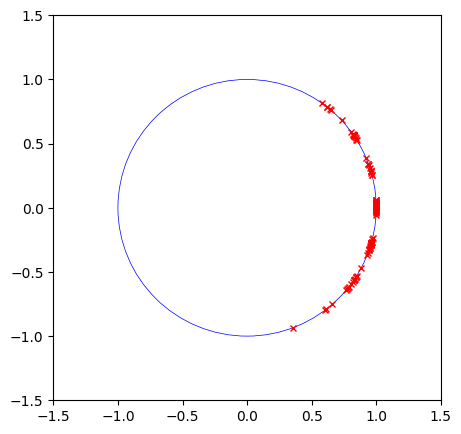

In [119]:
ma = np.array(result_m[10][0]['frechet']['mean'])
plt.figure(figsize=(5,5))

plt.plot(ma[:,0],ma[:,1],'x',markersize=5,c='red')

c1 = plt.Circle((0,0),radius=1,fill=False,color='blue',linewidth=0.51)
plt.gca().add_artist(c1)

plt.axis([-1.5,1.5,-1.5,1.5])
# plt.axis('equal')


## Making dataframe of mean estimation from result dictionary data of simulation 1

In [ ]:
# sample means
mest_label_map = {
    'frechet':  ['Fréchet', '-'],
    'huber_90': ['Huber', 'π/2'],
    'huber_45': ['Huber', 'π/4'],
    'biweight': ["Tukey's biweight", 'π/2'],
    'hampel': ["Hampel", 'π/4,π/2,3π/4'],
    'cauchy': ["Cauchy", 'π/2'],
}

mests = ['biweight','hampel','cauchy','huber_90','huber_45','frechet']
ns = [10,20,50,100,500,1000,5000,10000]

def mest_strip(mest):
    name, cutoff = mest_label_map[mest]
    return "$L^2 loss$\n(Fréchet mean)" if mest == "frechet" else f"{name}\n(Cutoff: {cutoff})"

rows = []
for n in ns:
    for mest in mests:
        ma = np.array(result_m[n][0][mest]['mean'])
        ys = ma[:, 1]
        xs = ma[:, 0]
        theta = np.arctan2(ys, xs)
        for x,y,t in zip(xs,ys,theta):
            rows.append({"n": n, "M-estimator": mest_strip(mest), "m_est":mest, "x":x, "y":y, "theta": t})
df = pd.DataFrame(rows)
df.to_csv('result_smeary_circle_means_simul_1.csv',index=False)

In [ ]:
# variance of sample means
var_df = pd.DataFrame(var_of_sample_means).reset_index()
var_df = var_df.melt(value_vars=var_df.columns[1:],id_vars=['index'])
var_df['value'] = [i[0] for i in var_df['value']]
var_df.columns = ['m_est','n','var_mu_n']
print(var_df.shape)
var_df = var_df.merge(
    var_df.loc[var_df.m_est=='frechet',['n','var_mu_n']],
    on=['n'],how='left',suffixes=('','_fm')
)
print(var_df.shape)
var_df['RE'] = var_df['var_mu_n_fm']/var_df['var_mu_n']

sample, theta_sample = sample_from_mixture_vm_u_in_circle(
                n_samples=1000000,
                mu=0,
                kappa=100,
                unif_low=np.pi-delta/2,
                unif_upp=np.pi+delta/2,
                mixture_prob_1=mixture_prob_1,
                return_before_mixture=False
            )
rmv_X = rrm.riemannian_variance(cc,sample,base=np.array([1.0,0.0]))
var_df['var_X'] = rmv_X
var_df['modulation'] = var_df['n'] * var_df['var_mu_n'] / var_df['var_X']
var_df['M-estimator'] = [mest_strip(mest) for mest in var_df['m_est']]
var_df.to_csv('result_smeary_circle_varofmeans_simul_1.csv',index=False)

(48, 3)
(48, 4)
(1000000, 2)


## Read result dataframe already made from simulation 1
* df : for plotting circle means histogram
* var_df : for plotting variance, modulation and RE of circle means 

In [149]:
df = pd.read_csv('result_smeary_circle_means_simul_1.csv')
var_df = pd.read_csv('result_smeary_circle_varofmeans_simul_1.csv')

In [226]:
df.head()

,n,M-estimator,m_est,x,y,theta
0,10,Tukey's biweight\n(Cutoff: π/2),biweight,0.999542,-0.030246,-0.030250
1,10,Tukey's biweight\n(Cutoff: π/2),biweight,1.000000,-0.000163,-0.000163
2,10,Tukey's biweight\n(Cutoff: π/2),biweight,0.999320,-0.036861,-0.036869
3,10,Tukey's biweight\n(Cutoff: π/2),biweight,0.999647,-0.026585,-0.026589
4,10,Tukey's biweight\n(Cutoff: π/2),biweight,0.999675,0.025498,0.025500


In [227]:
var_df.head()

,m_est,n,var_mu_n,var_mu_n_fm,RE,var_X,modulation,M-estimator
0,biweight,10,0.001421,0.212454,149.562801,1.094806,0.012975,Tukey's biweight\n(Cutoff: π/2)
1,hampel,10,0.001419,0.212454,149.730255,1.094806,0.012960,"Hampel\n(Cutoff: π/4,π/2,3π/4)"
2,cauchy,10,0.002815,0.212454,75.459887,1.094806,0.025716,Cauchy\n(Cutoff: π/2)
3,huber_90,10,0.100209,0.212454,2.120119,1.094806,0.915309,Huber\n(Cutoff: π/2)
4,huber_45,10,0.023263,0.212454,9.132640,1.094806,0.212487,Huber\n(Cutoff: π/4)


# Histogram for various sample means

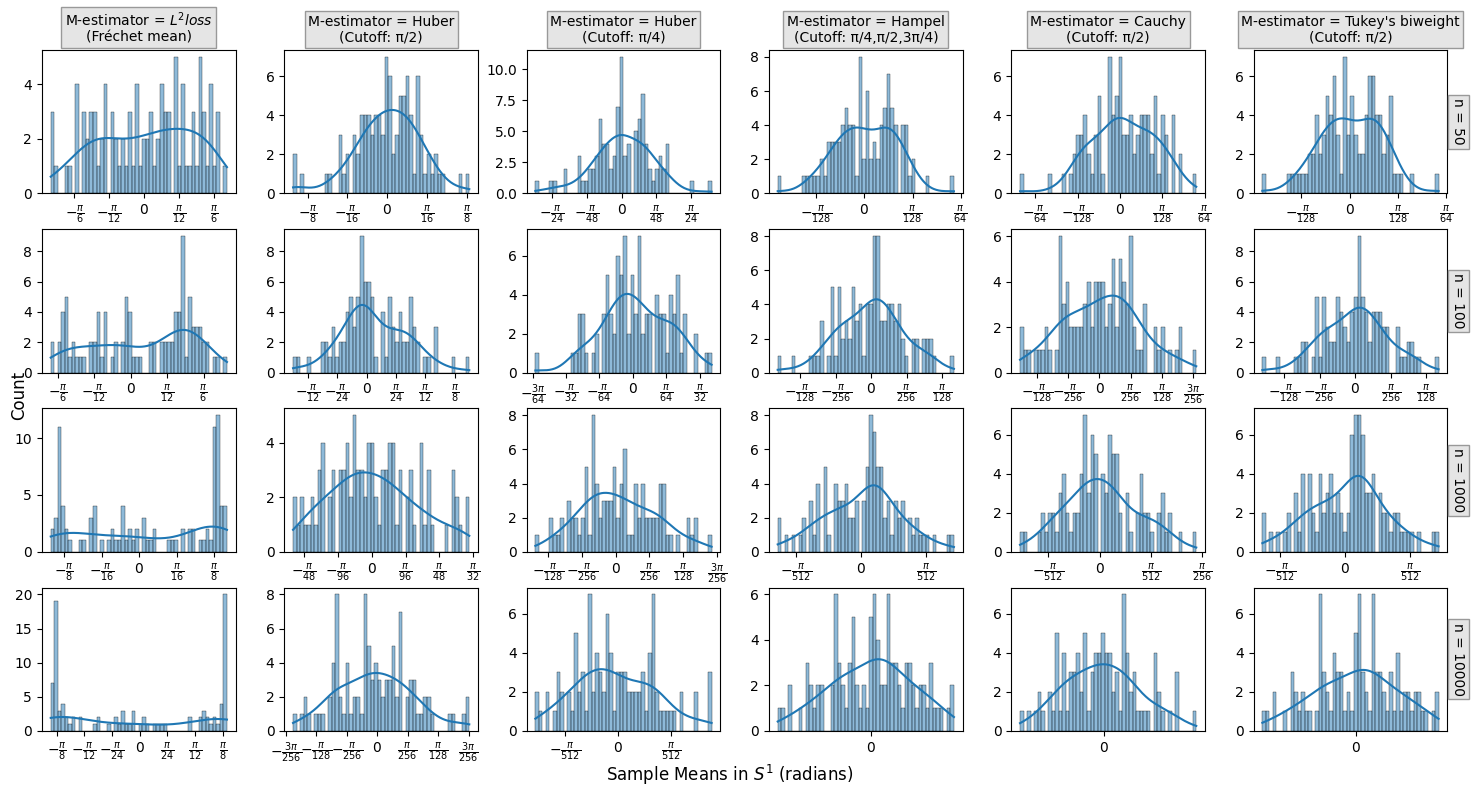

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from fractions import Fraction
from math import gcd
from scipy import stats

mests = ['frechet', 'huber_90', 'huber_45', 'hampel','cauchy', 'biweight']
ns = [50, 100, 1000, 10000] #, 10000]


# --- facet label 만들기 (열 strip에 들어갈 텍스트) ---
mest_label_map = {
    'frechet':  ['Fréchet', '-'],
    'huber_90': ['Huber', 'π/2'],
    'huber_45': ['Huber', 'π/4'],
    'biweight': ["Tukey's biweight", 'π/2'],
    'hampel': ["Hampel", 'π/4,π/2,3π/4'],
    'cauchy': ["Cauchy", 'π/2'],
}
def mest_strip(mest):
    name, cutoff = mest_label_map[mest]
    return "$L^2 loss$\n(Fréchet mean)" if mest == "frechet" else f"{name}\n(Cutoff: {cutoff})"


# --- π 배수 라벨 formatter (LaTeX 스타일) ---
def pi_formatter_tex(x, pos):
    frac = Fraction(x/np.pi).limit_denominator(12)
    n, d = frac.numerator, frac.denominator
    if n == 0:
        return r"$0$"
    sign = "-" if n < 0 else ""
    n = abs(n)

    if d == 1:
        return rf"${sign}\pi$" if n == 1 else rf"${sign}{n}\pi$"
    else:
        return rf"${sign}\frac{{\pi}}{{{d}}}$" if n == 1 else rf"${sign}\frac{{{n}\pi}}{{{d}}}$"

def set_pi_ticks_auto(ax, target_ticks=6, denoms=(1,2,3,4,6,8,12,16,24,32,48,64,128,256)):
    xmin, xmax = ax.get_xlim()
    span = abs(xmax - xmin)
    if span <= 0:
        return

    candidates = [np.pi/d for d in denoms]  # 간격 후보들: π, π/2, π/3, ...
    # tick 개수가 target_ticks 근처가 되도록 base 선택
    def score(base):
        nt = span / base
        # tick이 너무 적으면 큰 페널티(“사라짐” 방지)
        penalty = 1000 if nt < 2 else 0
        return abs(nt - target_ticks) + penalty

    base = min(candidates, key=score)

    ax.xaxis.set_major_locator(mticker.MultipleLocator(base))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(pi_formatter_tex))

def make_pi_formatter_from_base(base):
    # base ≈ π/q 라고 보고 q 추정
    q = int(round(np.pi / base))
    if q <= 0:
        q = 1

    def _fmt(x, pos):
        # x ≈ k * base 이므로 k를 추정 (부동소수 오차 보정)
        k = int(round(x / base))

        if k == 0:
            return r"$0$"

        sign = "-" if k < 0 else ""
        k = abs(k)

        # kπ/q를 기약분수로
        g = gcd(k, q)
        n = k // g
        d = q // g

        if d == 1:
            return rf"${sign}\pi$" if n == 1 else rf"${sign}{n}\pi$"
        else:
            if n == 1:
                return rf"${sign}\frac{{\pi}}{{{d}}}$"
            return rf"${sign}\frac{{{n}\pi}}{{{d}}}$"

    return mticker.FuncFormatter(_fmt)

def set_pi_ticks_auto(ax, target_ticks=6, denoms=(1,2,3,4,6,8,12,16,24,32,48,64,96,128,256,512)):
    xmin, xmax = ax.get_xlim()
    span = abs(xmax - xmin)
    if span <= 0:
        return

    # 후보 간격: π/d
    bases = [np.pi/d for d in denoms]

    # tick이 너무 적어지는 걸 강하게 페널티
    def score(b):
        nt = span / b
        penalty = 1e6 if nt < 2 else 0
        return abs(nt - target_ticks) + penalty

    base = min(bases, key=score)

    ax.xaxis.set_major_locator(mticker.MultipleLocator(base))
    ax.xaxis.set_major_formatter(make_pi_formatter_from_base(base))


def qqplot_normal(data, x, ax=None, **kws):
    if ax is None:
        ax = plt.gca()

    y = data[x].dropna().to_numpy()
    if y.size < 3:
        return

    q, y_sorted = stats.probplot(y, dist="norm", fit=False)  # (theoretical, sample)
    sns.scatterplot(x=q, y=y_sorted, ax=ax, s=18, edgecolor=None)

    lo = min(np.min(q), np.min(y_sorted))
    hi = max(np.max(q), np.max(y_sorted))
    ax.plot([lo, hi], [lo, hi])

    ax.set_xlabel("")
    ax.set_ylabel("")
    

# facet 순서 고정(원하는 순서대로)
col_order = [mest_strip(m) for m in mests]
row_order = ns

# --- FacetGrid: ggplot facet처럼 row/col strip를 "바깥"에 ---
g = sns.FacetGrid(
    df,  # 사용 dataframe
    row="n", col="M-estimator",
    row_order=row_order, col_order=col_order,
    margin_titles=True,      # strip를 margin에 배치 (공간 효율 핵심)
    sharex=False, sharey=False,
    height=2.0, aspect=1.25, # 패널 크기 조절
    despine=False
)

##################################
# 아래에서 bin 개수 조정 가능함.
##################################
g.map_dataframe(sns.histplot, x="theta", bins=50, kde=True)
# g.map_dataframe(qqplot_normal, x="theta", bins=25, kde=True)

# --- π 배수 눈금 적용 + 여백/라벨 다듬기 ---
for ax in g.axes.flat:
    set_pi_ticks_auto(ax, target_ticks=6)
    # ax.set_xlim(-np.pi, np.pi)
    # ax.xaxis.set_major_locator(mticker.MultipleLocator(base=np.pi/8))  # 예: π/2 간격
    # ax.xaxis.set_major_formatter(mticker.FuncFormatter(pi_formatter_tex))

# (B) strip을 네모 박스로 감싸기 (map 이후!)
strip_bbox = dict(boxstyle="square,pad=0.25",
                  facecolor="#E5E5E5", edgecolor="#999999", linewidth=1.0)

# col strip = 맨 위 행 axes의 title
for ax in g.axes[0, :]:
    ax.title.set_bbox(strip_bbox)

# row strip = 마지막 열 axes의 texts (margin_titles=True일 때)
for ax in g.axes[:, -1]:
    for t in ax.texts:
        # row strip만 골라서 bbox 주고 싶으면 텍스트 내용으로 필터링 가능
        t.set_bbox(strip_bbox)
        t.set_rotation(270)
        t.set_ha("left")
        t.set_va("center")
        
# 축 라벨은 전체에 한 번만(ggplot처럼)
g.set_axis_labels("", "")  # 개별 축 라벨 제거
g.fig.supxlabel("\nSample Means in $S^1$ (radians)")
g.fig.supylabel("Count")

# subplot 간격(필요시)
g.fig.subplots_adjust(wspace=0.25, hspace=0.25,bottom=0.08)

# plt.show()
os.makedirs('plots',exist_ok=True)
plt.savefig('plots/redescending_CLT_circle.png')
plt.savefig('plots/redescending_CLT_circle.pdf')
plt.savefig('plots/redescending_CLT_circle.eps')
# plt.savefig('plots/redescending_CLT_circle_qq.png')
# plt.savefig('plots/redescending_CLT_circle_qq.pdf')
# plt.savefig('plots/redescending_CLT_circle_qq.eps')

# QQ plots for various sample means(100 means per each)

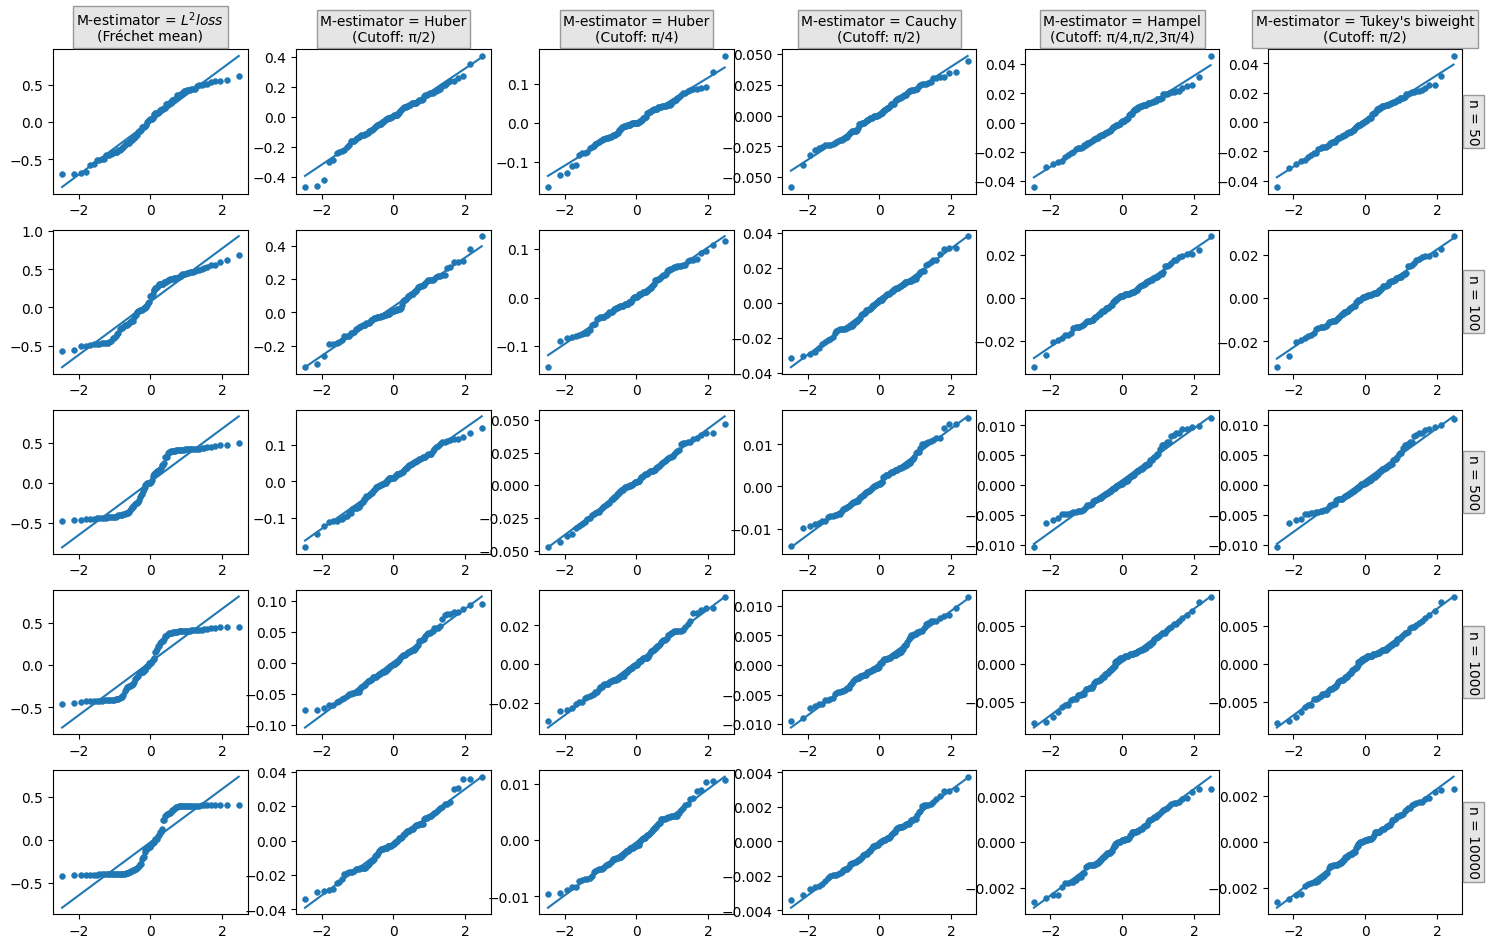

In [ ]:
# set m_estimators(with order), ns for plotting
mests = ['frechet', 'huber_90', 'huber_45','cauchy','hampel','biweight']
ns = [50, 100, 500, 1000, 10000] #, 10000] #, 10000]


def qqplot_normal(data, x, ax=None, **kws):
    if ax is None:
        ax = plt.gca()

    y = data[x].dropna().to_numpy()
    if y.size < 3:
        return

    (q, y_sorted), (slope, intercept, r) = stats.probplot(y, dist="norm", fit=True)  # (theoretical, sample)
    sns.scatterplot(x=q, y=y_sorted, ax=ax, s=18, edgecolor=None)

    # lo = min(np.min(q), np.min(y_sorted))
    # hi = max(np.max(q), np.max(y_sorted))
    # ax.plot([lo, hi], [lo, hi])
    ax.plot(q, intercept + slope * q)

    ax.set_xlabel("")
    ax.set_ylabel("")


# # --- 결과를 long-form DataFrame으로 변환 (FacetGrid는 이 형태가 제일 편함) ---
# rows = []
# for n in ns:
#     for mest in mests:
#         ma = np.array(result_m[n][0][mest]['mean'])
#         theta = np.arctan2(ma[:, 1], ma[:, 0])
#         for t in theta:
#             rows.append({"n": n, "M-estimator": mest_strip(mest), "theta": t})

# df = pd.DataFrame(rows)

# facet 순서 고정(원하는 순서대로)
col_order = [mest_strip(m) for m in mests]
row_order = ns

# --- FacetGrid: ggplot facet처럼 row/col strip를 "바깥"에 ---
g = sns.FacetGrid(
    df,
    row="n", col="M-estimator",
    row_order=row_order, col_order=col_order,
    margin_titles=True,      # strip를 margin에 배치 (공간 효율 핵심)
    sharex=False, sharey=False,
    height=2.0, aspect=1.25, # 패널 크기 조절
    despine=False
)

# g.map_dataframe(sns.histplot, x="theta", bins=25, kde=True)
g.map_dataframe(qqplot_normal, x="theta", bins=25, kde=True)

# --- π 배수 눈금 적용 + 여백/라벨 다듬기 ---
# for ax in g.axes.flat:
#     set_pi_ticks_auto(ax, target_ticks=6)
    # ax.set_xlim(-np.pi, np.pi)
    # ax.xaxis.set_major_locator(mticker.MultipleLocator(base=np.pi/8))  # 예: π/2 간격
    # ax.xaxis.set_major_formatter(mticker.FuncFormatter(pi_formatter_tex))

# (B) strip을 네모 박스로 감싸기 (map 이후!)
strip_bbox = dict(boxstyle="square,pad=0.25",
                  facecolor="#E5E5E5", edgecolor="#999999", linewidth=1.0)

# col strip = 맨 위 행 axes의 title
for ax in g.axes[0, :]:
    ax.title.set_bbox(strip_bbox)

# row strip = 마지막 열 axes의 texts (margin_titles=True일 때)
for ax in g.axes[:, -1]:
    for t in ax.texts:
        # row strip만 골라서 bbox 주고 싶으면 텍스트 내용으로 필터링 가능
        t.set_bbox(strip_bbox)
        t.set_rotation(270)
        t.set_ha("left")
        t.set_va("center")
        
# 축 라벨은 전체에 한 번만(ggplot처럼)
g.set_axis_labels("", "")  # 개별 축 라벨 제거
# g.fig.supxlabel("\nSample Means in $S^1$ (radians)")
# g.fig.supylabel("Count")

# subplot 간격(필요시)
g.fig.subplots_adjust(wspace=0.25, hspace=0.25,bottom=0.08)

# plt.show()
# plt.savefig('plots/redescending_CLT_circle.png')
# plt.savefig('plots/redescending_CLT_circle.pdf')
# plt.savefig('plots/redescending_CLT_circle.eps')
plt.savefig('plots/redescending_CLT_circle_qq.png')
plt.savefig('plots/redescending_CLT_circle_qq.pdf')
plt.savefig('plots/redescending_CLT_circle_qq.eps')

## only for biweight means

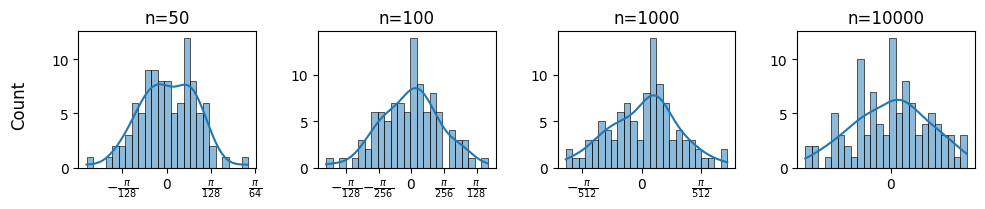

In [135]:
mest = 'biweight'
fig,ax = plt.subplots(1,4,figsize=(10,2.2))
for i,n in enumerate([50,100,1000,10000]):
    ma = np.array(result_m[n][0][mest]['mean'])
    theta = np.arctan2(ma[:, 1], ma[:, 0])
    sns.histplot(theta,bins=25,ax=ax[i],kde=True)
    ax[i].set_title(f'n={n}')
    ax[i].set_ylabel("") 
fig.supylabel("Count")
for x_ in ax:
    set_pi_ticks_auto(x_, target_ticks=6)
plt.tight_layout()

plt.savefig('plots/redescending_CLT_circle_biweight_only.png')
plt.savefig('plots/redescending_CLT_circle_biweight_only.pdf')
plt.savefig('plots/redescending_CLT_circle_biweight_only.eps')

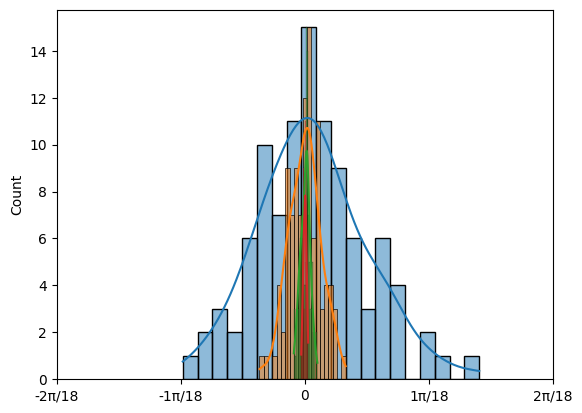

In [35]:
mest = 'biweight'
for n in [10,100,1000,10000]:
    ma = np.array(result_m[n][0][mest]['mean'])
    theta_ma = np.arctan2(ma[:,1],ma[:,0])
    sns.histplot(theta_ma,bins=20,kde=True,label=f'n={n}')
    plt.xticks(np.linspace(-np.pi/18,np.pi/18,5),[f'{i:.0f}π/18' if i!=0 else 0 for i in np.arange(-2,3)])

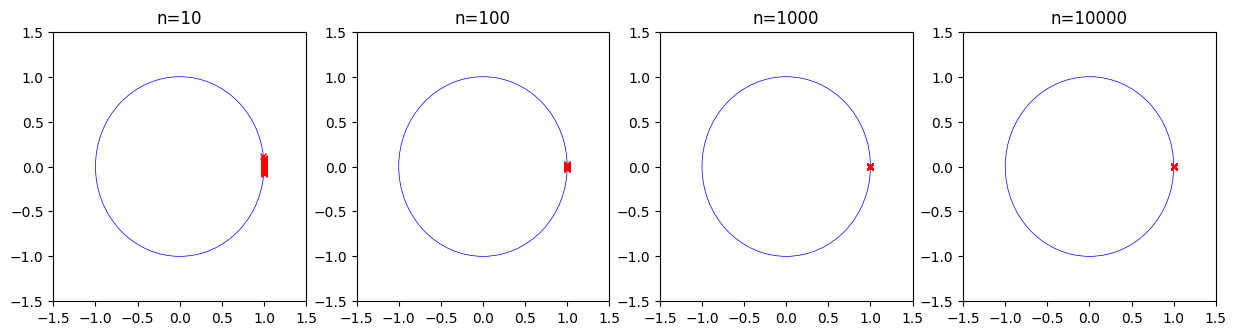

In [36]:
mest = 'biweight'
fig,ax = plt.subplots(1,4,figsize=(15,3.5))
for i,n in enumerate([10,100,1000,10000]):
    ma = np.array(result_m[n][0][mest]['mean'])
    ax[i].plot(ma[:,0],ma[:,1],'x',markersize=5,c='red')
    
    c1 = plt.Circle((0,0),radius=1,fill=False,color='blue',linewidth=0.51)
    ax[i].add_artist(c1)
    
    ax[i].axis([-1.5,1.5,-1.5,1.5])
    # fig.suptitle(f'100 Sample means examples')
    ax[i].set_title(f'n={n}')

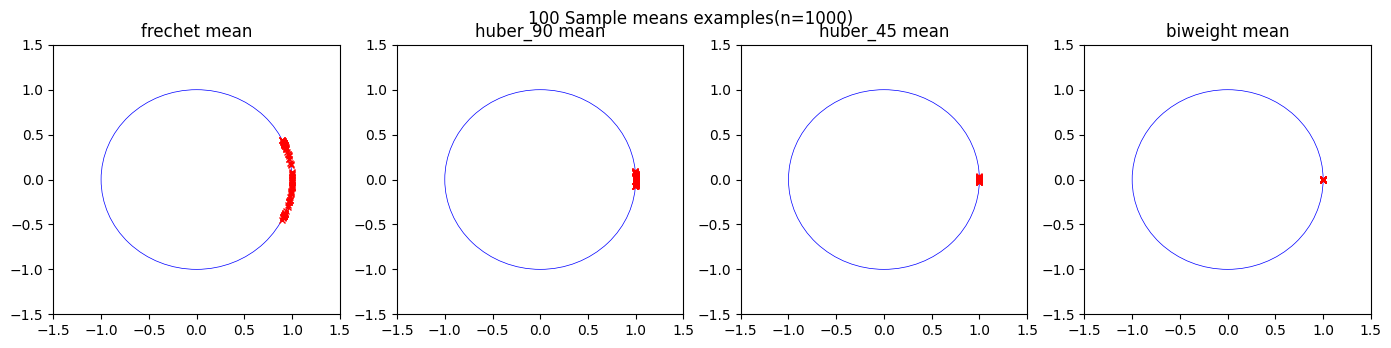

In [43]:
n = 1000
fig,ax = plt.subplots(1,4,figsize=(17,3.5))
for i,mest in enumerate(['frechet','huber_90','huber_45','biweight']):
    ma = np.array(result_m[n][0][mest]['mean'])
    ax[i].plot(ma[:,0],ma[:,1],'x',markersize=5,c='red')
    
    c1 = plt.Circle((0,0),radius=1,fill=False,color='blue',linewidth=0.51)
    ax[i].add_artist(c1)
    
    ax[i].axis([-1.5,1.5,-1.5,1.5])
    fig.suptitle(f'100 Sample means examples(n={n})\n')
    ax[i].set_title(f'{mest} mean')

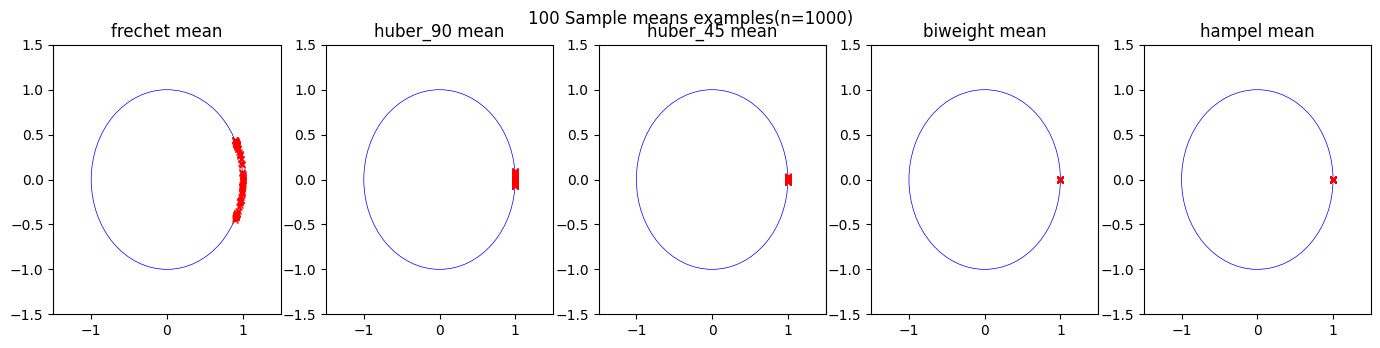

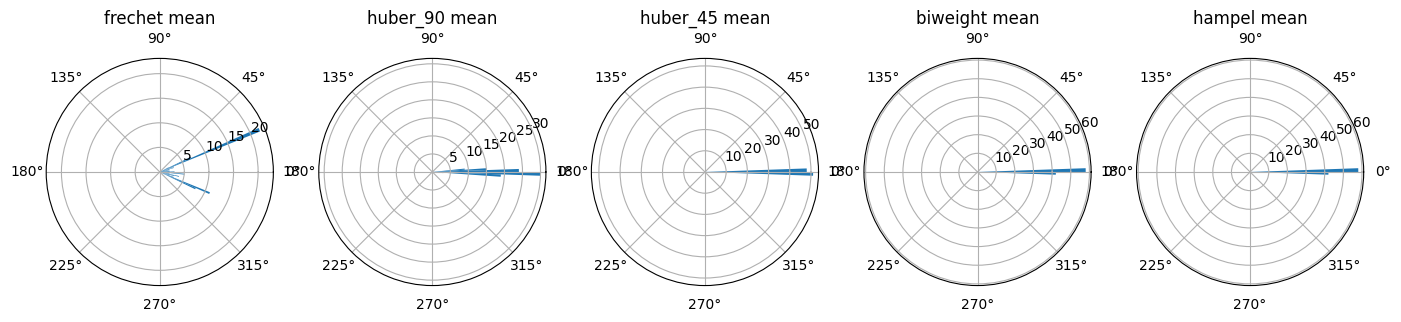

In [45]:
n = 1000

fig,ax = plt.subplots(1,5,figsize=(17,3.5))
for i,mest in enumerate(['frechet','huber_90','huber_45','biweight','hampel']):
    ma = np.array(result_m[n][0][mest]['mean'])
    ax[i].plot(ma[:,0],ma[:,1],'x',markersize=5,c='red')
    
    c1 = plt.Circle((0,0),radius=1,fill=False,color='blue',linewidth=0.51)
    ax[i].add_artist(c1)
    
    ax[i].axis([-1.5,1.5,-1.5,1.5])
    fig.suptitle(f'100 Sample means examples(n={n})')
    ax[i].set_title(f'{mest} mean')
    # ax[i].axis('equal')

fig,ax = plt.subplots(1,5,figsize=(17,3.5),subplot_kw={'projection':'polar'})
# plt.subplot(projection="polar")
plt.title(f"Sampling Distribution: {mixture_prob_1:.3f}*VM({kappa:.0f})+{1-mixture_prob_1:.3f}*U(7$\pi$/8 ~ 9$\pi$/8)")
for i,mest in enumerate(['frechet','huber_90','huber_45','biweight','hampel']):
    ma = np.array(result_m[n][0][mest]['mean'])
    theta_ma = np.arctan2(ma[:,1],ma[:,0])
    ax[i].hist(theta_ma,bins=180,alpha=1,range=(-np.pi, np.pi)) #,label=f'{0.5+epsilon:.2f}*VM(0,{kappa:.0f})+{0.5-epsilon}*VM($\pi$,100)')
    ax[i].set_title(f'{mest} mean')
    # ax[i].axis('equal')

# (plotting) Variance, modulation of M-estimators  - simulation 1

In [46]:
mests = ['biweight','hampel','cauchy','huber_90','huber_45','frechet']
ns = [10,20,50,100,500,1000,5000,10000]

In [154]:
var_df.head()

,m_est,n,var_mu_n,var_mu_n_fm,RE,var_X,modulation,M-estimator
0,biweight,10,0.001421,0.212454,149.562801,1.094806,0.012975,Tukey's biweight\n(Cutoff: π/2)
1,hampel,10,0.001419,0.212454,149.730255,1.094806,0.012960,"Hampel\n(Cutoff: π/4,π/2,3π/4)"
2,cauchy,10,0.002815,0.212454,75.459887,1.094806,0.025716,Cauchy\n(Cutoff: π/2)
3,huber_90,10,0.100209,0.212454,2.120119,1.094806,0.915309,Huber\n(Cutoff: π/2)
4,huber_45,10,0.023263,0.212454,9.132640,1.094806,0.212487,Huber\n(Cutoff: π/4)


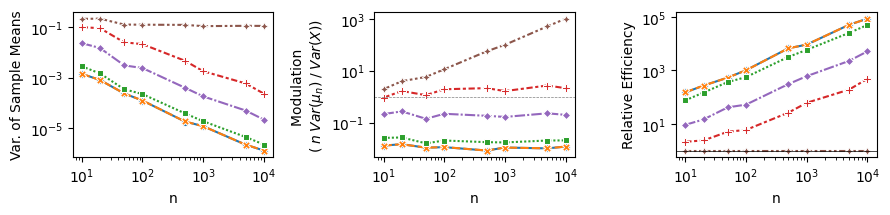

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(9,2.25))
sns.lineplot(x='n',hue='m_est',y='var_mu_n',data=var_df,ax=ax[0],style='m_est',markers=True,errorbar=None)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('Var. of Sample Means')
# ax[0].axis('equal')

sns.lineplot(x='n',hue='m_est',y='modulation',data=var_df,ax=ax[1],style='m_est',markers=True,errorbar=None)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('Modulation \n($ \; n\;Var(\mu_n) \; / \; Var(X) $)')
# ax[1].plot([10,10000],[10,10000],'--',c='gray',alpha=0.8,linewidth=0.5)
ax[1].axhline(y=1,c='gray',linewidth=0.5,linestyle='--')
# ax[1].axis('equal')

sns.lineplot(x='n',hue='m_est',y='RE',data=var_df,ax=ax[2],style='m_est',markers=True,errorbar=None)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_ylabel('Relative Efficiency')

ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].axhline(y=1,c='black',linewidth=0.5,linestyle='-')
# ax[2].legend(bbox_to_anchor=(1.01,1))
ax[2].legend_.remove()
plt.tight_layout()
os.makedirs('plots',exist_ok=True)
plt.savefig('plots/modulation_simulation1.png')
plt.savefig('plots/modulation_simulation1.pdf')
plt.savefig('plots/modulation_simulation1.eps')

# Simulation 2 data sampling

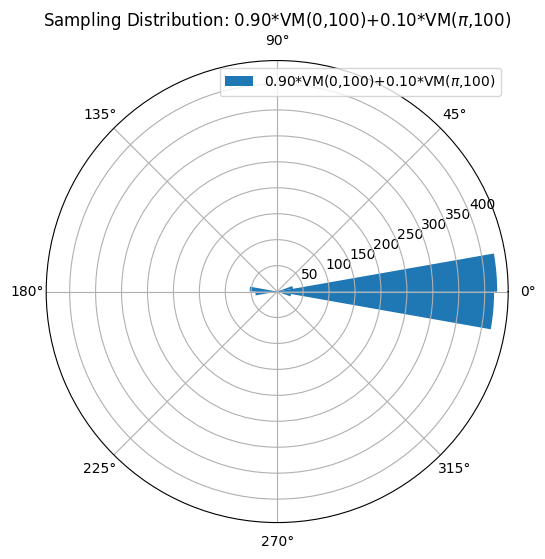

In [171]:
n_samples=1000
def sample_from_mixture_vm_2_in_circle(n_samples,mu,kappa,mu2,kappa2,mixture_prob_1,return_before_mixture=False):
    # 1) 각도 샘플
    theta = vonmises.rvs(kappa, loc=mu, size=n_samples)
    
    # 2) circle(S¹) 위의 점으로 매핑
    x = np.stack([np.cos(theta), np.sin(theta)], axis=-1)
    
    theta2 = vonmises.rvs(kappa2, loc=mu2, size=n_samples)
    x2 = np.stack([np.cos(theta2), np.sin(theta2)], axis=-1)

    mixture_mask = np.random.uniform(size=n_samples)<=mixture_prob_1

    sample = np.array([x[i,:] if m else x2[i,:] for i,m in enumerate(mixture_mask)])
    theta_sample = np.array([theta[i] if m else theta2[i] for i,m in enumerate(mixture_mask)])
    if return_before_mixture:
        return sample, theta_sample, theta, theta2
    return sample, theta_sample

epsilon = 0.4
sample, theta_sample = sample_from_mixture_vm_2_in_circle(
    n_samples=n_samples,
    mu=0,
    kappa=100,
    mu2=np.pi,
    kappa2=100,
    mixture_prob_1=0.5+epsilon
)

plt.figure(figsize=(6,6))
plt.subplot(projection="polar")
plt.hist(theta_sample,bins=36,alpha=1,label=f'{0.5+epsilon:.2f}*VM(0,{kappa:.0f})+{0.5-epsilon:.2f}*VM($\pi$,100)')
plt.title(f"Sampling Distribution: {0.5+epsilon:.2f}*VM(0,{kappa:.0f})+{0.5-epsilon:.2f}*VM($\pi$,100)")
plt.legend()
plt.show()


# Simulation 2 start

In [ ]:
ns = [10,20,50,100,500,1000,5000,10000]
epsilons = [0.05,0.1,0.2,0.3,0.375,0.4,0.45]
mests = ['frechet','huber_90','huber_45','biweight','hampel','cauchy']
mest_label_map = {
    'frechet':  ['Fréchet', '-'],
    'huber_90': ['Huber', 'π/2'],
    'huber_45': ['Huber', 'π/4'],
    'biweight': ["Tukey's biweight", 'π/2'],
    'hampel': ["Hampel", 'π/4,π/2,3π/4'],
    'cauchy': ["Cauchy", 'π/2'],
}

In [ ]:
cc = Hypersphere(1)

var_of_sample_means_ = {}
mean_of_sample_vars_ = {}
min_loss_sp_ = {}
result_m_ = {}
result_a_ = {}
tic = time.time()
for n_samples in ns:
    print(f'{n_samples} start')
    result_m_[n_samples] = {}
    result_a_[n_samples] = {}
    var_of_sample_means_[n_samples] = {}
    mean_of_sample_vars_[n_samples] = {}
    min_loss_sp_[n_samples] = {}
    for epsilon in epsilons:
        result_m_[n_samples][epsilon] = {}
        result_a_[n_samples][epsilon] = {}
        var_of_sample_means_[n_samples][epsilon] = {mest:[] for mest in mests}
        mean_of_sample_vars_[n_samples][epsilon] = {mest:[] for mest in mests}
        min_loss_sp_[n_samples][epsilon] = {mest:[] for mest in mests}
        for ix in range(1):
            result_m_[n_samples][epsilon][ix] = {mest:{'mean':[],'var':[]} for mest in mests}
            result_a_[n_samples][epsilon][ix] = {mest:[] for mest in mests}
        
            for iter in range(100):
                sample, theta_sample, theta, theta_op = sample_from_mixture_vm_2_in_circle(
                    n_samples=n_samples,
                    mu=0,
                    kappa=100,
                    mu2=np.pi,
                    kappa2=100,
                    mixture_prob_1=0.5+epsilon,
                    return_before_mixture=True
                )
                for m in mests:
                    cutoff = np.pi/2 if m in ['biweight','hampel','huber_90'] else np.pi/4
                    mest_rs = []
                    for i_sp,sp in enumerate([[1.0,0.0],[-1.0,0.0],[0.0,1.0],[0.0,-1.0]]):
                        mest_0 = rrm.RiemannianRobustMestimator(
                            space=cc,
                            critical_value=cutoff,
                            m_estimator=m.split('_')[0] if m!='frechet' else 'custom',
                            method='default',
                            init_point_method='mean-projection'
                        )
                        if m=='frechet':
                            mest_0.set_loss(squaredist)
                        mest_0.set(epsilon=1e-7, max_iter=1024, init_point=gs.array(sp))
                        mest_0.fit(sample)
                        mest_rs.append(mest_0)
                    loss_by_sp = np.array([l.estimate_.losses[-1] for l in mest_rs])
                    min_i_sp = np.argmin(loss_by_sp)
                    mest = mest_rs[min_i_sp]
                    min_loss_sp_[n_samples][epsilon][m].append(min_i_sp)
                    # print(m,iter,min_i_sp)
                        
                    if len(mest.estimate_.losses)<=1000:
                        result_m_[n_samples][epsilon][ix][m]['mean'].append(mest.estimate_.x)
                        result_m_[n_samples][epsilon][ix][m]['var'].append(
                            rrm.riemannian_variance(cc,sample,gs.array([1.0,0.0]))
                        )
                        result_a_[n_samples][epsilon][ix][m].append(mest.estimate_)
                    else:
                        print(f'{n_samples}:{m}({iter}) invalid, not optimized.')
                if (iter+1)%50==0:
                    print(f'({epsilon})_{ix}[{iter+1}] finished! {time.time()-tic:.2f} seconds elapsed...')
            
            for m in mests:
                means = np.array([i for i in result_m_[n_samples][epsilon][ix][m]['mean']])
                var_of_sample_means_[n_samples][epsilon][m].append(rrm.riemannian_variance(cc,means))

                vars = np.array([i for i in result_m_[n_samples][epsilon][ix][m]['var']])
                mean_of_sample_vars_[n_samples][epsilon][m].append(np.mean(vars))

# Simulation 2 data saving

In [ ]:
folder = 'result_data_base'
with open(f'{folder}/var_of_sample_means_simul2.pkl','wb') as f_:
    pickle.dump(var_of_sample_means_,f_)
with open(f'{folder}/mean_of_sample_vars_simul2.pkl','wb') as f_:
    pickle.dump(mean_of_sample_vars_,f_)
with open(f'{folder}/var_of_sample_means_simul2_result_mean.pkl','wb') as f_:
    pickle.dump(result_m_,f_)

with open(f'{folder}/var_of_sample_means_simul2_result_a.pkl','wb') as f_:
    pickle.dump(result_a_,f_)

In [ ]:
var(mu_hat) = σ**2/n*k , k=1이면 평균의 분산은 O(n**-1) 크기
var(mu_hat)/(표본평균의 분산)   O(n**-1) 보다 더 크다. n에 비례해서 올라감.

# make data as dataframe before plotting

In [ ]:
ns = [10,20,50,100,500,1000,5000,10000]
epsilons = [0.05,0.1,0.2,0.3,0.375,0.4,0.45]
mests = ['frechet','huber_90','huber_45','biweight','hampel','cauchy']
mest_label_map = {
    'frechet':  ['Fréchet', '-'],
    'huber_90': ['Huber', 'π/2'],
    'huber_45': ['Huber', 'π/4'],
    'biweight': ["Tukey's biweight", 'π/2'],
    'hampel': ["Hampel", 'π/4,π/2,3π/4'],
    'cauchy': ["Cauchy", 'π/2'],
}

In [222]:
# sample means
rows = []
for n in ns:
    for eps in epsilons:
        for mest in mests:
            ma = np.array(result_m_[n][eps][0][mest]['mean'])
            ys = ma[:, 1]
            xs = ma[:, 0]
            theta = np.arctan2(ys, xs)
            for x,y,t in zip(xs,ys,theta):
                rows.append({"n": n, "epsilon":eps, "M-estimator": mest_strip(mest), "m_est":mest, "x":x, "y":y, "theta": t})
df_2 = pd.DataFrame(rows)
print(df_2.shape)
df_2.to_csv('result_smeary_circle_means_simul_2.csv',index=False)

(33544, 7)


In [ ]:
# variance of sample means
var_df_2 = pd.DataFrame()
for i,epsilon in enumerate(epsilons):
    rdf = pd.DataFrame()
    for n_samples in ns:
        d_ = pd.DataFrame(var_of_sample_means_[n_samples][epsilon])
        d_['n'] = n_samples
        rdf = pd.concat((rdf,d_),axis=0)
    rdf['epsilon'] = epsilon
    rdf = rdf.melt(id_vars=['n','epsilon'],value_vars=mests,)
    var_df_2 =  pd.concat((var_df_2,rdf),axis=0)
var_df_2.columns = ['n','epsilon','m_est','var_mu_n']

eps_var_X = []
for eps in epsilons:
    sample, theta_sample = sample_from_mixture_vm_2_in_circle(
        n_samples=1000000,
        mu=0,
        kappa=100,
        mu2=np.pi,
        kappa2=100,
        mixture_prob_1=0.5+eps
    )
    print(sample.shape)
    rmv_X = rrm.riemannian_variance(cc,sample,base=np.array([1.0,0.0]))
    eps_var_X.append([eps,rmv_X])
eps_var_X = pd.DataFrame(eps_var_X,columns=['epsilon','var_X'])


print(var_df_2.shape)
var_df_2 = var_df_2.merge(
    var_df_2.loc[var_df_2['m_est']=='frechet'].drop('m_est',axis=1),on=['n','epsilon'],suffixes=('','_fm'),how='left'
)
print(var_df_2.shape)
var_df_2['RE'] = var_df_2['var_mu_n_fm']/var_df_2['var_mu_n']

print(var_df_2.shape)
var_df_2 = var_df_2.merge(eps_var_X,on=['epsilon'],how='left')
print(var_df_2.shape)
var_df_2['modulation'] = var_df_2['n'] * var_df_2['var_mu_n'] / var_df_2['var_X']
var_df_2['M-estimator'] = [mest_strip(mest) for mest in var_df_2['m_est']]
var_df_2.to_csv('result_smeary_circle_varofmeans_simul_2.csv',index=False)

## Read result dataframe already made from simulation 2
* df_2 : for plotting circle means histogram
* var_df_2 : for plotting variance, modulation and RE of circle means 

In [223]:
df_2 = pd.read_csv('result_smeary_circle_means_simul_2.csv')
var_df_2 = pd.read_csv('result_smeary_circle_varofmeans_simul_2.csv')


# plotting of modulation of sample means(4 types) - simulation 2

In [185]:
# pre-setting
ns = [10,20,50,100,500,1000,5000,10000]
epsilons = [0.05,0.1,0.2,0.3,0.375,0.4,0.45]
mests = ['frechet','huber_90','huber_45','biweight','hampel','cauchy']
mest_label_map = {
    'frechet':  ['Fréchet', '-'],
    'huber_90': ['Huber', 'π/2'],
    'huber_45': ['Huber', 'π/4'],
    'biweight': ["Tukey's biweight", 'π/2'],
    'hampel': ["Hampel", 'π/4,π/2,3π/4'],
    'cauchy': ["Cauchy", 'π/2'],
}

7021.608977596864
0.0024172823151583566


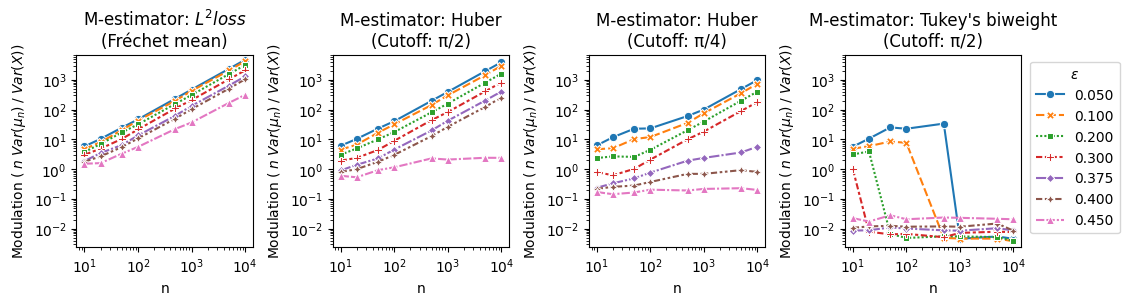

In [215]:

fig,ax = plt.subplots(1,4,figsize=(9,2.5))
for j,mest in enumerate(['frechet','huber_90','huber_45','biweight']): # ,'hampel','cauchy']):
    # m_label,m_cutoff = mest_label_map[mest]
    rda1 = var_df_2.loc[(var_df_2['m_est']==mest)].copy()
    rda1['epsilon'] = [f'{i:.3f}' for i in rda1['epsilon']]
    sns.lineplot(x='n',y='modulation',data=rda1,ax=ax[j],
                 hue='epsilon',errorbar=None,style='epsilon',markers=True)
    ax[j].set_ylabel('Modulation ($ \; n\;Var(\mu_n) \; / \; Var(X) $)')
    # ax[j].set_title(f'M-estimator: {m_label} \n(Cutoff:{m_cutoff})' if mest!='frechet' else f'{m_label} mean\n')
    ax[j].set_title(f'M-estimator: {mest_strip(mest)}')
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    if j==0:
        _,ymax2 = ax[j].get_ylim()
        print(ymax2)
    if j==3:
        ymin2,_ = ax[j].get_ylim()
        print(ymin2)
    
    if j!=3:
        ax[j].legend_.remove()
    else:
        ax[j].legend(title=r"$\epsilon$", loc='upper left',bbox_to_anchor=(1.01,1))
# ax[1,2].set_yscale('log')

for j in range(4):
    ax[j].set_ylim(ymin2,ymax2+0.1)

fig.subplots_adjust(wspace=0.45,left=-0.15)
os.makedirs('plots',exist_ok=True)
fig.savefig("plots/modulation_simul2_4m.eps", bbox_inches="tight")   
fig.savefig("plots/modulation_simul2_4m.pdf", bbox_inches="tight")   
fig.savefig("plots/modulation_simul2_4m.png", bbox_inches="tight") 

# plotting of modulation of sample means(6 types)

7021.608977596864
0.0024172823151583566


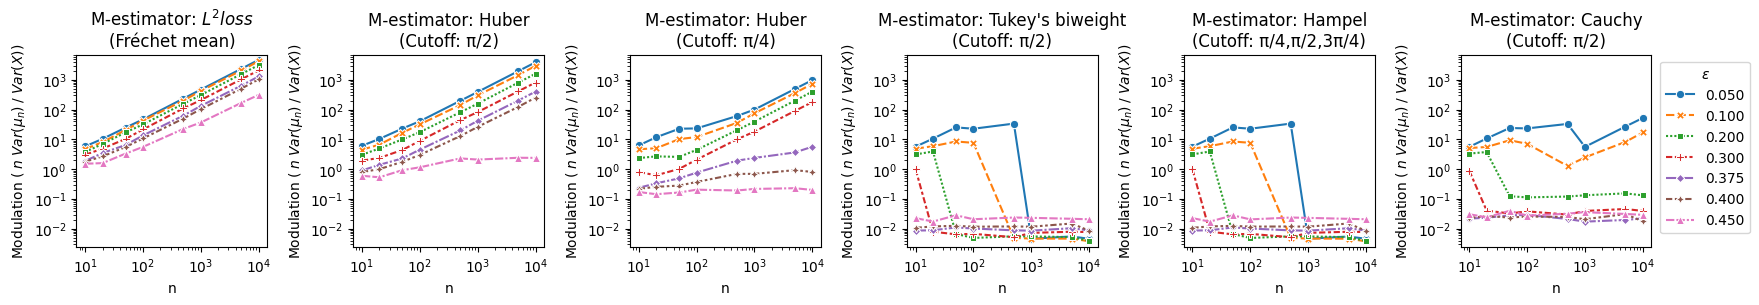

In [216]:

fig,ax = plt.subplots(1,6,figsize=(15,2.5))
for j,mest in enumerate(['frechet','huber_90','huber_45','biweight','hampel','cauchy']):
    #m_label,m_cutoff = mest_label_map[mest]
    rda1 = var_df_2.loc[(var_df_2['m_est']==mest)].copy()
    rda1['epsilon'] = [f'{i:.3f}' for i in rda1['epsilon']]
    sns.lineplot(x='n',y='modulation',data=rda1,ax=ax[j],
                 hue='epsilon',errorbar=None,style='epsilon',markers=True)
    ax[j].set_ylabel('Modulation ($ \; n\;Var(\mu_n) \; / \; Var(X) $)')
    #ax[j].set_title(f'M-estimator: {m_label} \n(Cutoff:{m_cutoff})' if mest!='frechet' else f'{m_label} mean\n')/
    ax[j].set_title(f'M-estimator: {mest_strip(mest)}')
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    if j==0:
        _,ymax2 = ax[j].get_ylim()
        print(ymax2)
    if j==3:
        ymin2,_ = ax[j].get_ylim()
        print(ymin2)
    
    if j!=5:
        ax[j].legend_.remove()
    else:
        ax[j].legend(title=r"$\epsilon$", loc='upper left',bbox_to_anchor=(1.01,1))
# ax[1,2].set_yscale('log')

for j in range(6):
    ax[j].set_ylim(ymin2,ymax2+0.1)

fig.subplots_adjust(wspace=0.45,left=-0.15)
os.makedirs('plots',exist_ok=True)
fig.savefig("plots/modulation_simul2.eps", bbox_inches="tight")   
fig.savefig("plots/modulation_simul2.pdf", bbox_inches="tight")   
fig.savefig("plots/modulation_simul2.png", bbox_inches="tight") 

# (not used in paper) Variance, Modulation, RE plotting for all - simulation 2

3.182686981734329
7021.608977596864
3.8634102520814555e-07
0.0024172823151583566
0 (np.float64(3.8634102520814555e-07), np.float64(3.282686981734329))
1 (np.float64(3.8634102520814555e-07), np.float64(3.282686981734329))
2 (np.float64(3.8634102520814555e-07), np.float64(3.282686981734329))
3 (np.float64(3.8634102520814555e-07), np.float64(3.282686981734329))


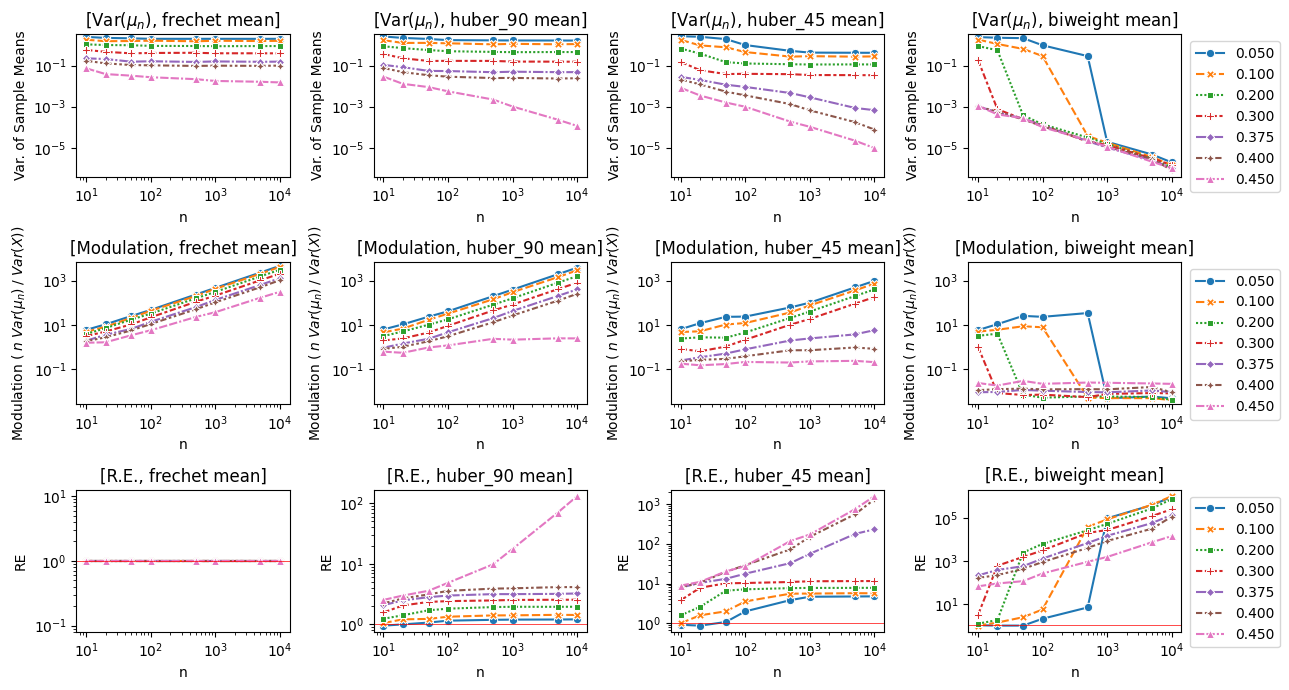

In [217]:
fig,ax = plt.subplots(3,4,figsize=(13,7))
for j,mest in enumerate(['frechet','huber_90','huber_45','biweight']):
    m_label,m_cutoff = mest_label_map[mest]
    rda1 = var_df_2.loc[(var_df_2['m_est']==mest)].copy()
    rda1['epsilon'] = [f'{i:.3f}' for i in rda1['epsilon']]
    sns.lineplot(x='n',y='var_mu_n',data=rda1,ax=ax[0,j],
                 hue='epsilon',errorbar=None,style='epsilon',markers=True)
    ax[0,j].set_ylabel('Var. of Sample Means')
    ax[0,j].set_title(f'[Var($\mu_n$), {mest} mean]')
    ax[0,j].set_xscale('log')
    ax[0,j].set_yscale('log')
    if j==0:
        _,ymax = ax[0,j].get_ylim()
        print(ymax)
    if j==3:
        ymin,_ = ax[0,j].get_ylim()
        print(ymin)

    sns.lineplot(x='n',y='modulation',data=rda1,ax=ax[1,j],
                 hue='epsilon',errorbar=None,style='epsilon',markers=True)
    ax[1,j].set_ylabel('Modulation ($ \; n\;Var(\mu_n) \; / \; Var(X) $)')
    ax[1,j].set_title(f'[Modulation, {mest} mean]')
    ax[1,j].set_xscale('log')
    ax[1,j].set_yscale('log')
    if j==0:
        _,ymax2 = ax[1,j].get_ylim()
        print(ymax2)
    if j==3:
        ymin2,_ = ax[1,j].get_ylim()
        print(ymin2)
    

    ax[2,j].set_title(f'[R.E., {mest} mean]')
    sns.lineplot(x='n',y='RE',data=rda1,ax=ax[2,j],
                 hue='epsilon',errorbar=None,style='epsilon',markers=True)
    ax[2,j].set_xscale('log')
    ax[2,j].set_yscale('log')
    ax[2,j].axhline(y=1,linewidth=0.5,c='red',linestyle='-')
    
    if j!=3:
        ax[0,j].legend_.remove()
        ax[1,j].legend_.remove()
        ax[2,j].legend_.remove()
    else:
        ax[0,j].legend(bbox_to_anchor=(1.01,1))
        ax[1,j].legend(bbox_to_anchor=(1.01,1))
        ax[2,j].legend(bbox_to_anchor=(1.01,1))
# ax[1,2].set_yscale('log')

for j in range(4):
    ax[0,j].set_ylim(ymin,ymax+0.1)
    ax[1,j].set_ylim(ymin2,ymax2+0.1)
    print(j,ax[0,j].get_ylim())
    
plt.tight_layout()


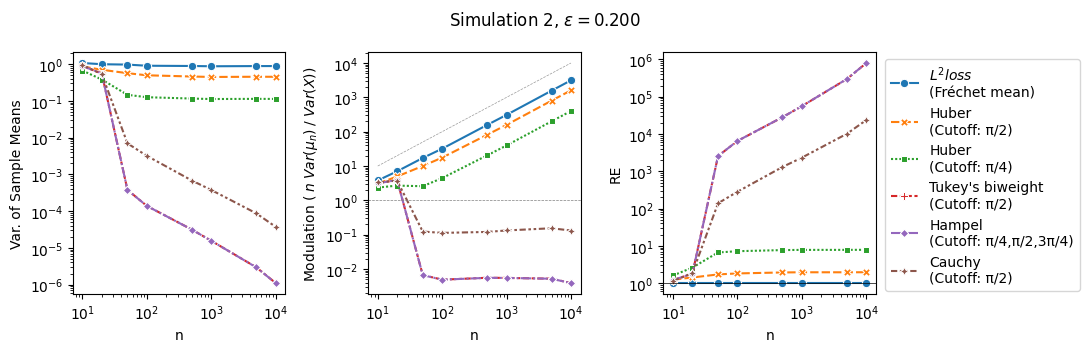

In [218]:
eps = 0.2
rda375 = var_df_2.loc[(var_df_2.epsilon==eps)].copy()

fig,ax = plt.subplots(1,3,figsize=(11,3.55))
fig.suptitle(f'Simulation 2, $\epsilon={eps:.3f}$')
sns.lineplot(x='n',hue='M-estimator',y='var_mu_n',data=rda375,ax=ax[0],style='M-estimator',markers=True,errorbar=None)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('Var. of Sample Means')
# ax[0].axis('equal')

sns.lineplot(x='n',hue='M-estimator',y='modulation',data=rda375,ax=ax[1],style='M-estimator',markers=True,errorbar=None)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('Modulation ($ \; n\;Var(\mu_n) \; / \; Var(X) $)')
ax[1].plot([10,10000],[10,10000],'--',c='gray',alpha=0.8,linewidth=0.5)
ax[1].axhline(y=1,c='gray',linewidth=0.5,linestyle='--')
# ax[1].axis('equal')

sns.lineplot(x='n',hue='M-estimator',y='RE',data=rda375,ax=ax[2],style='M-estimator',markers=True,errorbar=None)
ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].axhline(y=1,c='black',linewidth=0.5,linestyle='-')
ax[2].legend(bbox_to_anchor=(1.01,1))
plt.tight_layout()

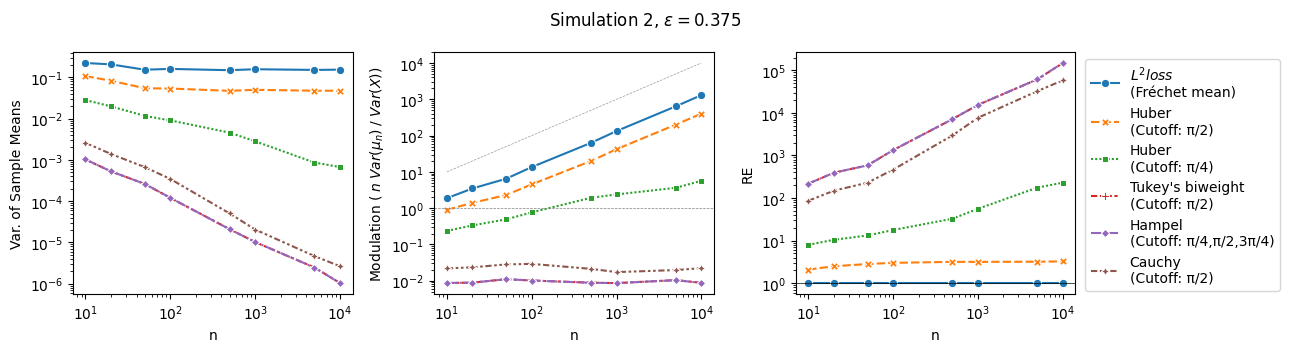

In [219]:
rda375 = var_df_2.loc[(var_df_2.epsilon==0.375)].copy()

fig,ax = plt.subplots(1,3,figsize=(13,3.55))
fig.suptitle('Simulation 2, $\epsilon=0.375$')
sns.lineplot(x='n',hue='M-estimator',y='var_mu_n',data=rda375,ax=ax[0],style='M-estimator',markers=True,errorbar=None)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('Var. of Sample Means')
# ax[0].axis('equal')

sns.lineplot(x='n',hue='M-estimator',y='modulation',data=rda375,ax=ax[1],style='M-estimator',markers=True,errorbar=None)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('Modulation ($ \; n\;Var(\mu_n) \; / \; Var(X) $)')
ax[1].plot([10,10000],[10,10000],'--',c='gray',alpha=0.8,linewidth=0.5)
ax[1].axhline(y=1,c='gray',linewidth=0.5,linestyle='--')
# ax[1].axis('equal')

sns.lineplot(x='n',hue='M-estimator',y='RE',data=rda375,ax=ax[2],style='M-estimator',markers=True,errorbar=None)
ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[0].legend_.remove()
ax[1].legend_.remove()
ax[2].axhline(y=1,c='black',linewidth=0.5,linestyle='-')
ax[2].legend(bbox_to_anchor=(1.01,1))
plt.tight_layout()

## Plotting for Mean location behavior while optimizing(for only one case's mean optimizing movement)
### (works only after simulation 2 is complete)

KeyError: 1000

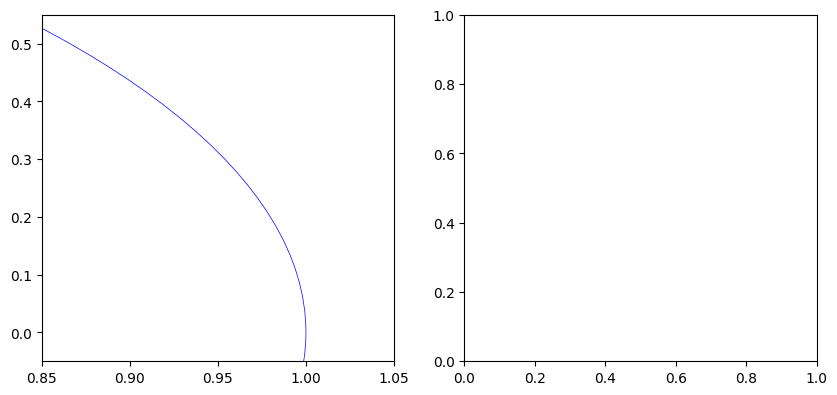

In [61]:
fig,ax = plt.subplots(1,2,figsize=(10,4.5))
ix = 20

c1 = plt.Circle((0,0),radius=1,fill=False,color='blue',linewidth=0.51)
ax[0].add_artist(c1)
ax[0].axis([0.85,1.05,-0.05,0.55])

base = np.array(result_a_[1000][0.3][0]['huber_45'][ix].bases)
ax[0].plot(base[:,0],base[:,1],'x',markersize=5,c='green')
for ss in range(0,len(base),10):
    x,y = base[ss]
    ax[0].text(x,y,s=int(ss),fontsize=10 if i>0 else 20,alpha=1 if i in [0,len(base)-1] else 0.5)
ax[0].text(base[0][0],base[0][1],s=int(0),fontsize=20,c='red')
ax[0].text(base[-1][0],base[-1][1],s=int(ss),fontsize=20,c='red')
#base_end = result_a_[5000][0.3][0]['huber_90'][0].bases[-1]
ax[1].plot(result_a_[5000][0.3][0]['huber_90'][ix].losses[5:])
ax[1].set_yscale('log')
print(base[0],base[-1])
plt.tight_layout()

## Plotting for 100 different Mean locations per each sample mean by n, $\varepsilon$

frechet 100
huber_90 100
huber_45 100
biweight 100


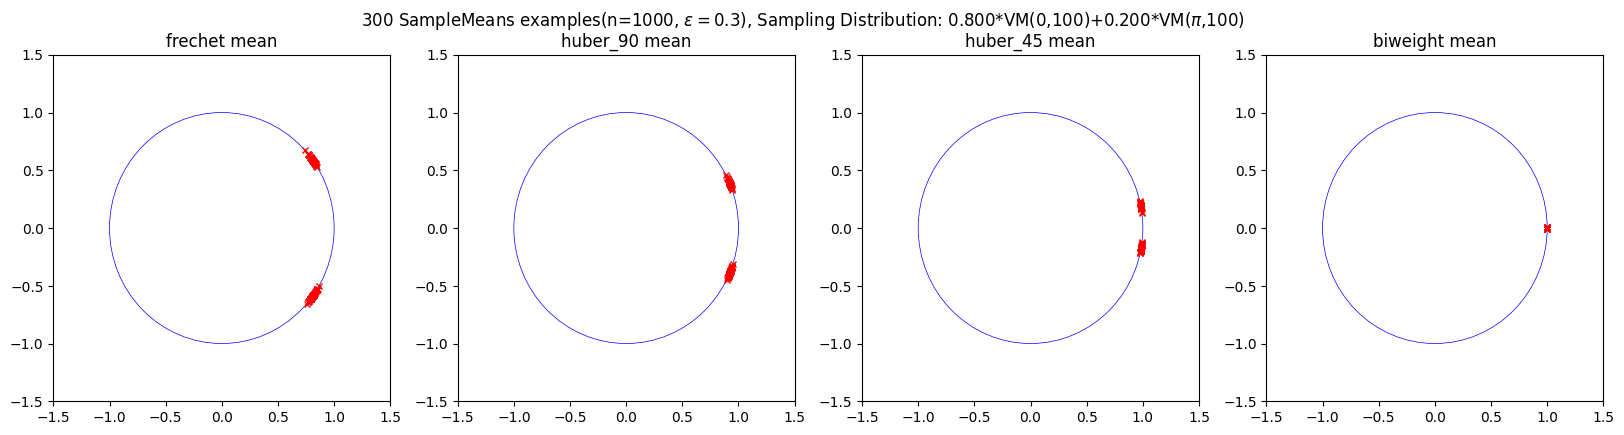

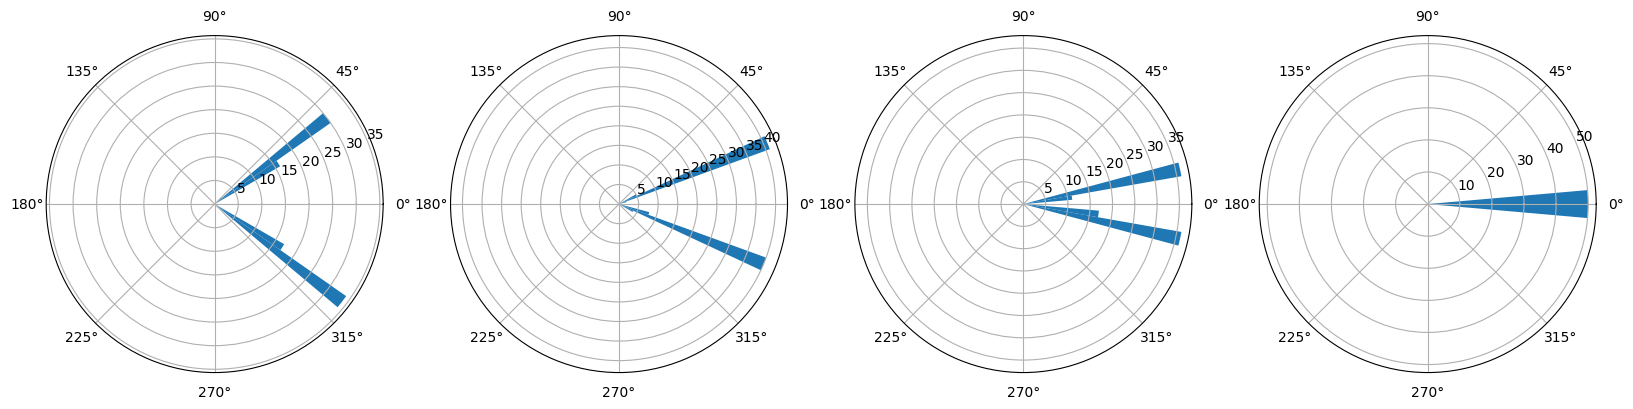

In [224]:
n = 1000
eps = 0.3
fig,ax = plt.subplots(1,4,figsize=(20,4.5))
for i,mest in enumerate(['frechet','huber_90','huber_45','biweight']):
    # ma = np.array(result_m_[n][eps][0][mest]['mean'])
    ma = np.array(
        df_2.loc[(df_2['m_est']==mest) & 
                 (df_2['epsilon']==eps) & 
                 (df_2['n']==n),
                 ['x','y']]
                )
    print(mest,len(ma))
    ax[i].plot(ma[:,0],ma[:,1],'x',markersize=5,c='red')
    
    c1 = plt.Circle((0,0),radius=1,fill=False,color='blue',linewidth=0.51)
    ax[i].add_artist(c1)
    
    ax[i].axis([-1.5,1.5,-1.5,1.5])
    
    ax[i].set_title(f'{mest} mean')
    # ax[i].axis('equal')
fig.suptitle(f'300 SampleMeans examples(n={n}, $\epsilon={eps}$), Sampling Distribution: {0.5+eps:.3f}*VM(0,{kappa:.0f})+{0.5-eps:.3f}*VM($\pi$,100)\n')
# plt.tight_layout()
fig,ax = plt.subplots(1,4,figsize=(20,4.5),subplot_kw={'projection':'polar'})
# plt.subplot(projection="polar")

for i,mest in enumerate(['frechet','huber_90','huber_45','biweight']):
    ma = np.array(result_m_[n][eps][0][mest]['mean'])
    theta_ma = np.arctan2(ma[:,1],ma[:,0])
    ax[i].hist(theta_ma,bins=72,alpha=1,range=(-np.pi, np.pi)) #,label=f'{0.5+epsilon:.2f}*VM(0,{kappa:.0f})+{0.5-epsilon}*VM($\pi$,100)')
    # ax[i].set_title(f'{mest} mean')
    # ax[i].axis('equal')


# Load all simulation results

In [ ]:
import pickle
folder = 'result_data_base'
with open(f'{folder}/var_of_sample_means_simul1.pkl','rb') as f_:
    var_of_sample_means = pickle.load(f_)
with open(f'{folder}/mean_of_sample_vars_simul1.pkl','rb') as f_:
    mean_of_sample_vars = pickle.load(f_)
with open(f'{folder}/var_of_sample_means_simul1_result_mean.pkl','rb') as f_:
    result_m = pickle.load(f_)

with open(f'{folder}/var_of_sample_means_simul1_result_a.pkl','rb') as f_:
    result_a = pickle.load(f_)

with open(f'{folder}/var_of_sample_means_simul2.pkl','rb') as f_:
    var_of_sample_means_ = pickle.load(f_)
with open(f'{folder}/mean_of_sample_vars_simul2.pkl','rb') as f_:
    mean_of_sample_vars_ = pickle.load(f_)
with open(f'{folder}/var_of_sample_means_simul2_result_mean.pkl','rb') as f_:
    result_m_ = pickle.load(f_)

with open(f'{folder}/var_of_sample_means_simul2_result_a.pkl','rb') as f_:
    result_a_ = pickle.load(f_)


EOFError: Ran out of input